# Generating the container 

In [29]:
import sys
print(sys.path)
import matplotlib.pyplot as plt
import numpy as np

from dataclasses import dataclass

from typing import List, Tuple

from ri_grad.components import *

['/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '', '/home/vini/Documents/refindex_gradient/.venv/lib64/python3.11/site-packages', '/home/vini/Documents/refindex_gradient/.venv/lib/python3.11/site-packages']


[(0, 24.5), (np.float64(22.27408320686851), 23.333333333333336), (np.float64(28.333809105422528), 21.666666666666668), (np.float64(32.62131035859634), 20.0), (np.float64(36.103156413856034), 18.333333333333332), (np.float64(39.09800001397663), 16.666666666666664), (np.float64(41.75713367973283), 14.999999999999998), (np.float64(44.166439423472994), 13.333333333333332), (np.float64(46.38024235857206), 11.666666666666666), (np.float64(48.435513266616645), 10.0), (np.float64(50.358778575266726), 8.333333333333334), (np.float64(52.1698489561435), 6.666666666666667), (np.float64(53.88399198577074), 5.0), (np.float64(55.51327577865208), 3.333333333333333), (np.float64(57.06744036973059), 1.6666666666666663), (np.float64(58.55448523306296), -4.440892098500626e-16)]


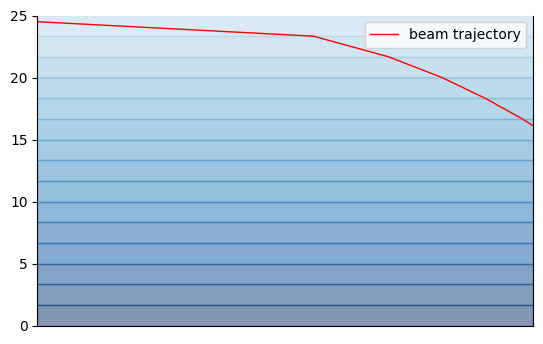

In [30]:
class Experiment:
    def __init__(self, container: Container, medium: Medium, beam: Beam, show_incidence_points: bool = False):
        self.container = container
        self.medium = medium
        self.beam = beam
        self.show_incidence_points = show_incidence_points

        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax

        self._container_drawn = False

    def render_container(self):
        plt.figure(self.fig.number)
        ax = self.ax

        ax.set_xlim(0, self.container.width)
        ax.set_ylim(0, self.container.height)
        ax.set_aspect('equal')

        # Remove top and right spines to resemble an aquarium
        ax.spines['top'].set_visible(False)

        # Keep only the bottom and left spines
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')

        # Remove ticks
        ax.set_xticks([])

        self._container_drawn = True

    def render_medium(self):
        if not self._container_drawn:
            self.render_container()

        n_layers = self.medium.n_layers

        # Generate a linear light to dark blue gradient
        gradient = np.linspace(.3, 1, n_layers)[::-1]
        colors = plt.cm.Blues(gradient)

        # Draw the layers with the generated colors
        ax = self.ax
        for i in range(n_layers):
            layer_height = i * (self.container.height / n_layers)
            ax.fill_between(
                [0, self.container.width], 
                layer_height, 
                layer_height + (self.container.height / self.medium.n_layers), 
                color=colors[i], 
                alpha=0.5
            )    

    def render_beam(self, points: List[Tuple[float]]):
        if not self._container_drawn:
            self.render_medium()

        x, y = zip(*points) 
        ax = self.ax
        ax.scatter(x, y, color='red', linewidth=2, label='incidence points') if self.show_incidence_points else None
        ax.plot(x, y, color='red', linewidth=1, label='beam trajectory')
        ax.legend()
            
    """
    Receives a beam, an incidence point and an incidence angle.
    Calculates the refraction angles and points for each layer in the medium.
    """
    def _refraction(self, layer1: Layer, layer2: Layer, incidence_angle: float):        
        return np.arcsin((layer1.n / layer2.n) * np.sin(incidence_angle))
    
    def _refraction(self, n1: float, n2: float, incidence_angle: float):        
        return np.arcsin((n1 / n2) * np.sin(incidence_angle))
    
    """
    Calculates the point of incidence on the next layer. 
    """
    def _transmission(self, incidence_point: Tuple[float], refracted_angle: float):
        x_offset = self.medium.layer_thickness * np.tan(refracted_angle)
        return (incidence_point[0] + x_offset, incidence_point[1] - self.medium.layer_thickness)

    """
    The first refraction is a special case because the beam incides on the side wall of the container.
    Returns the point of incidence on the first layer and the incidence angle.
    """
    def _first_refraction(self, incidence_point: Tuple[float], incidence_angle: float):
        incidence_layer = self.medium.get_layer_from_y(incidence_point[1])
        y_offset = - (incidence_point[1] - incidence_layer.y_0) # distance from the incidence point to the layer's top edge

        refracted_angle = self._refraction(1, incidence_layer.n, incidence_angle) # angle of refraction with the container wall
        x_offset = abs(y_offset / np.tan(refracted_angle))

        return ((incidence_point[0] + x_offset, incidence_layer.y_0), (np.pi/2) - refracted_angle)

    """"
    Calculates the trajectory of the beam through the medium.
    Returns a list of points where the beam incides on each interface.
    """
    def beam_on(self):        
        points: List[Tuple[float]] = [] # list of points where the beam incides on each interface
        incidence_point: Tuple[float] = (0, self.beam.y_0) # initial point of incidence on the first layer
        points.append(incidence_point)

        # first refraction
        incidence_point, incidence_angle = self._first_refraction((0, self.beam.y_0), self.beam.angle)
        points.append(incidence_point)

        # remaining refractions
        incident_layer_index = self.medium.get_layer_index_from_y(incidence_point[1]) # index of the layer where the beam incides
        for i in range(incident_layer_index, self.medium.n_layers):
            layer = self.medium.layers[i]
            next_layer = self.medium.layers[i + 1] if i + 1 < self.medium.n_layers else None
            
            if next_layer is None: # last layer, no refraction
                break
            
            refracted_angle = self._refraction(layer.n, next_layer.n, incidence_angle)
            # print(f"Layer {i}: incidence angle = {incidence_angle}, refracted angle = {refracted_angle}")
            incidence_point = self._transmission(incidence_point, refracted_angle)
            incidence_angle = refracted_angle
            points.append(incidence_point)

        return points
        

# experiment setup
container = Container(width=40, height=25)
medium = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=15, 
    color='blue'
)
beam = Beam(wavelength=500e-9, y_0=24.5, angle=0.05 * (np.pi/2))

experiment = Experiment(container, medium, beam)
# experiment.render_beam()
points = experiment.beam_on()
experiment.render_beam(points)
print(points)

[(0, 24.5), (np.float64(0.0), 24.5), (np.float64(2.2040866928515954), 24.25), (np.float64(3.851844636702972), 24.0), (np.float64(5.223402732584029), 23.75), (np.float64(6.422347144294106), 23.5), (np.float64(7.500322531071127), 23.25), (np.float64(8.487442196908697), 23.0), (np.float64(9.403070982062921), 22.75), (np.float64(10.260530021648831), 22.5), (np.float64(11.0694466656231), 22.25), (np.float64(11.837046520384604), 22.0), (np.float64(12.56891694861395), 21.75), (np.float64(13.26948435348348), 21.5), (np.float64(13.942326340678523), 21.25), (np.float64(14.590383614511179), 21.0), (np.float64(15.21610835873703), 20.75), (np.float64(15.821570924613535), 20.5), (np.float64(16.408538306970964), 20.25), (np.float64(16.978533022769838), 20.0), (np.float64(17.532878060874577), 19.75), (np.float64(18.072731730383037), 19.5), (np.float64(18.599115050875582), 19.25), (np.float64(19.112933547437297), 19.0), (np.float64(19.614994787196068), 18.75), (np.float64(20.106022632336956), 18.5), (n

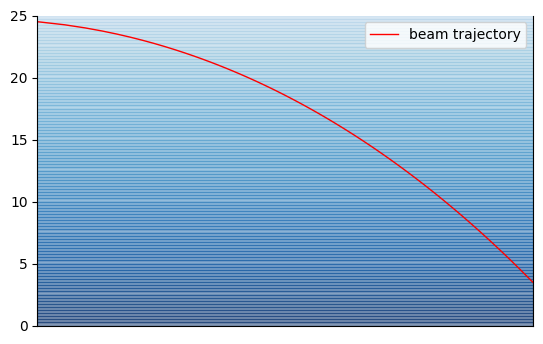

In [31]:
# experiment setup
container2 = Container(width=40, height=25)
medium2 = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=100, 
    color='blue'
)
beam2 = Beam(wavelength=500e-9, y_0=24.5, angle=0.05 * (np.pi/2))

experiment = Experiment(container2, medium2, beam2)
# experiment.render_beam()
points = experiment.beam_on()
experiment.render_beam(points)
print(points)

[(0, 24.5), (np.float64(0.0), 24.5), (np.float64(0.4555369032655669), 24.25), (np.float64(0.9015183924246546), 24.0), (np.float64(1.3384781736890234), 23.75), (np.float64(1.7669015545773892), 23.5), (np.float64(2.1872313924620905), 23.25), (np.float64(2.599873134035922), 23.0), (np.float64(3.0051991100006283), 22.75), (np.float64(3.4035522152924367), 22.5), (np.float64(3.7952490790366626), 22.25), (np.float64(4.180582808162688), 22.0), (np.float64(4.559825372764526), 21.75), (np.float64(4.933229688801226), 21.5), (np.float64(5.301031443812469), 21.25), (np.float64(5.663450703393518), 21.0), (np.float64(6.020693329790575), 20.75), (np.float64(6.372952238808637), 20.5), (np.float64(6.720408517013903), 20.25), (np.float64(7.063232417764905), 20.0), (np.float64(7.4015842517680115), 19.75), (np.float64(7.735615185504668), 19.5), (np.float64(8.065467958925733), 19.25), (np.float64(8.391277532178542), 19.0), (np.float64(8.71317166976576), 18.75), (np.float64(9.031271469384622), 18.5), (np.flo

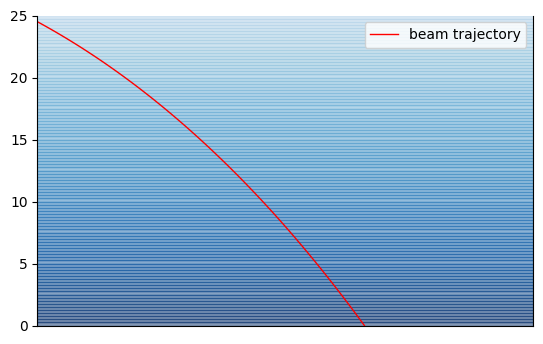

In [32]:
# experiment setup
container3 = Container(width=40, height=25)
medium3 = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=100, 
    color='blue'
)
beam3 = Beam(wavelength=500e-9, y_0=24.5, angle=0.5 * (np.pi/2))

experiment = Experiment(container3, medium3, beam3)
# experiment.render_beam()
points = experiment.beam_on()
experiment.render_beam(points)
print(points)

[(0, 24.5), (np.float64(0.4741078181270077), 24.474999999999678), (np.float64(0.8810501171844498), 24.44999999999968), (np.float64(1.243095683957579), 24.42499999999968), (np.float64(1.5724206094497266), 24.399999999999682), (np.float64(1.8765345963699749), 24.374999999999684), (np.float64(2.1604534757146223), 24.349999999999685), (np.float64(2.4277233170830783), 24.324999999999687), (np.float64(2.6809603871456122), 24.299999999999688), (np.float64(2.922160201816125), 24.27499999999969), (np.float64(3.1528859200265287), 24.24999999999969), (np.float64(3.37438907184719), 24.224999999999692), (np.float64(3.5876901360778404), 24.199999999999694), (np.float64(3.7936341674491456), 24.174999999999695), (np.float64(3.9929303097109505), 24.149999999999697), (np.float64(4.186180555695432), 24.124999999999698), (np.float64(4.373901127497143), 24.0999999999997), (np.float64(4.556538666719857), 24.0749999999997), (np.float64(4.73448269595662), 24.049999999999702), (np.float64(4.908075350124394), 2

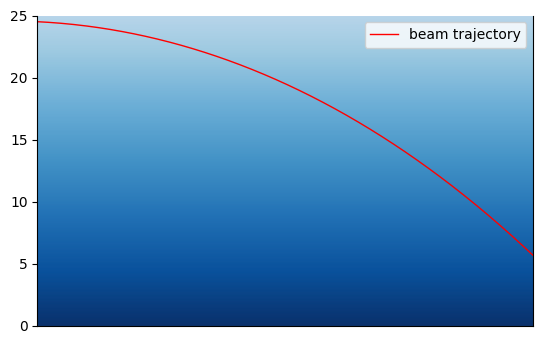

In [34]:
# experiment setup
container4 = Container(width=40, height=25)
medium4 = Medium(
    container,
    n_0=1.0, 
    n_f=1.5, 
    n_layers=1000, 
    color='blue'
)
beam4 = Beam(wavelength=500e-9, y_0=24.5, angle=0.05 * (np.pi/2))

experiment = Experiment(container4, medium4, beam4)
# experiment.render_beam()
points = experiment.beam_on()
experiment.render_beam(points)
print(points)